## Analyse des données

## Chargement des données, des librairies et des variables globales

In [1]:
import warnings

import pandas as pd
import plotnine as p9

from math import ceil

warnings.filterwarnings("ignore")

In [2]:
df_vtc_0 = pd.read_csv("../data/data_vtc_2023.csv")
df_livr_0 = pd.read_csv("../data/data_livraison_2023.csv")

In [3]:
df_vtc_0["Année"] = df_vtc_0["Année"].astype(str)
df_livr_0["Année"] = df_livr_0["Année"].astype(str)
df_vtc_0.replace(to_replace="2021", value="2021 (trimestre 4)", inplace=True)
df_livr_0.replace(to_replace="2021", value="2021 (trimestre 4)", inplace=True)

### Traitement des données

In [4]:
def get_df(df, attente=False):
    # Attributs communs pour une auto-jointure
    common_attributes = df.columns.tolist()
    common_attributes.remove("Variable")
    common_attributes.remove("Valeur")

    # Dataframes à join
    df_revenus = df[df["Variable"] == "revenu"]
    df_duree = df[df["Variable"] == "duree"]

    # Auto-jointure sur les attributs communs
    df_join_0 = pd.merge(
        df_revenus,
        df_duree,
        left_on=common_attributes,
        right_on=common_attributes,
    )

    # Si attente, on ajoute une auto-jointure avec l'attente et on renomme
    if attente:
        df_attente = df[df["Variable"] == "attente-proposition"]
        df_join = pd.merge(
            df_join_0,
            df_attente,
            left_on=common_attributes,
            right_on=common_attributes,
        )

        df_join.drop(["Variable_x", "Variable_y", "Variable"], axis=1, inplace=True)
        df_join.rename(
            columns={"Valeur_x": "revenu", "Valeur_y": "duree", "Valeur": "attente"},
            inplace=True,
        )

    # Sinon, on renomme simplement les variables
    else:
        df_join_0.drop(["Variable_x", "Variable_y"], axis=1, inplace=True)
        df_join_0.rename(
            columns={"Valeur_x": "revenu", "Valeur_y": "duree"}, inplace=True
        )
        df_join = df_join_0

    # Conversion en heures
    df_join["heures"] = df_join["duree"].apply(lambda x: x / 60)
    df_join["revenu_horaire"] = df_join["revenu"] / df_join["heures"]

    # Conversion en heures pour l'attente
    if attente:
        df_join["attente_heures"] = df_join["attente"].apply(lambda x: x / 60)
        df_join["revenu_horaire_avec_attente"] = df_join["revenu"] / (
            df_join["attente_heures"] + df_join["heures"]
        )

    # On supprime les horaires de repas (pour les livraisons)
    df_join = df_join[df_join["Période d'activité"] != "repas"]

    return df_join

In [5]:
df_vtc_attente = get_df(df_vtc_0, attente=True)
df_vtc = get_df(df_vtc_0)
df_livr_attente = get_df(df_livr_0, attente=True)
df_livr = get_df(df_livr_0)

## Analyse

### Notes préliminaires

Lorsque l'année 2021 apparait sur les graphiques, il s'agit uniquement de la période de septembre à décembre, alors que l'année 2022 correspond à 4 trimestres. 

Il existe dans la base de données trois indicateurs : 
- revenu et durée moyens par prestation
- revenu et durée moyens par semaine
- revenu et durée moyens par mois

De plus les indicateurs mentionnés sont définis en distinguant les catégories de travailleurs suivantes par semaine et par mois :
- Les travailleurs ayant effectué entre 1 et 10, 11 et 25, 26 et 40, plus de 40 prestations au cours de la semaine 
- Les travailleurs ayant effectué entre 3 et 30, 31 à 75, 76 et 120, plus de 120 prestations au cours du mois 

Comme les données publiées n'indiquent pas le volume de travailleurs par catégorie, sauf indication contraire, nous nous limitons respectivement 
aux travailleurs ayant effectué plus de 40 prestations au cours de la semaine et plus de 120 prestations au cours du mois. 

Les valeurs des indicateurs sont à interpréter avec précaution car la seule variable fournie pour chaque indicateur est la moyenne. Ainsi il n’y a pas d’indication sur de potentiels effets volumes (variation de la taille de l’échantillon) ou sur la distribution. 

### Analyse avec temps d'attente

Comme les travailleurs de plateformes, par la nature de leur travail, n'ont pas une plage horaire fixe pour effectuer plusieurs tâches, mais au contraire effectuent des tâches ou présestations qui peuvent avoir une durée variable et fragmentées sur le temps d'une journée. Ainsi il convient d'inclure dans l'étude le temps d'attente entre deux tâches ou prestations.  

Le temps d'attente figure parmi les indicateurs mentionnés dans le décret. Plus précisement, il est défini comme suit, dans l'Article 1 du décret 2021-501 du 22 avril 2021, 


3° Par “ temps d'attente avant de recevoir une proposition de prestation ” le temps cumulé, exprimé en minutes :
a) Entre le moment où le travailleur se connecte à la plateforme et le moment où celle-ci lui propose une prestation ;
b) Entre deux propositions de prestations faites par la plateforme au travailleur, déduction faite, si la prestation est acceptée par le travailleur, de la durée comprise entre l'acceptation de la prestation par le travailleur et la fin de celle-ci ;
c) Entre le moment où le travailleur se déconnecte de la plateforme et la dernière proposition de prestation faite par la plateforme, déduction faite, si la prestation est acceptée par le travailleur, de la durée comprise entre l'acceptation de la prestation par le travailleur et la fin de celle-ci. 

Dans les données pour le secteur livraison, seule la variable "Temps moyen avant proposition" est disponible. Pour le secteur des VTC, il y a une varibale supplémentaire renseignée uniquement par Cao Cao (2022), Uber et Heetch.  

Ces variables sont disponibles uniquement pour la durée d'une prestation (et non pas pour les différentes catégories de travailleurs par tranche de prestations qui sont données par mois et par semaine)

In [6]:
df_vtc_attente[
    (df_vtc_attente["Durée étudiée"] == "prestation")
    & (df_vtc_attente["Année"] == "2023")
    & (df_vtc_attente["Activité du travailleur"] == "toutes")
    & (df_vtc_attente["Période d'activité"] == "toutes")
]

Durée étudiée Activité du travailleur Période d'activité Plateforme Année  \
10     prestation                  toutes             toutes   ALLO CAB  2023   
25     prestation                  toutes             toutes  BLACKLANE  2023   
40     prestation                  toutes             toutes       BOLT  2023   
55     prestation                  toutes             toutes    CAO CAO  2023   
70     prestation                  toutes             toutes    FREENOW  2023   
85     prestation                  toutes             toutes     HEETCH  2023   
95     prestation                  toutes             toutes     LE CAB  2023   
105    prestation                  toutes             toutes     MARCEL  2023   
110    prestation                  toutes             toutes  SIXT RIDE  2023   
125    prestation                  toutes             toutes       UBER  2023   

     revenu  duree  attente    heures  revenu_horaire  attente_heures  \
10    37.04  25.80      0.5  0.430000       86.139535        0.008333   
25    96.56  53.58      NaN  0.893000      108.129899             NaN   
40    17.98  21.75      8.1  0.362500       49.600000        0.135000   
55    23.86  25.80      NaN  0.430000       55.488372             NaN   
70    12.20  24.10     19.3  0.401667       30.373444        0.321667   
85    12.90  23.00     10.8  0.383333       33.652174        0.180000   
95    37.50  34.00     20.0  0.566667       66.176471        0.333333   
105   38.30  33.00     22.0  0.550000       69.636364        0.366667   
110   82.94  46.20      NaN  0.770000      107.714286             NaN   
125   18.30  21.10      7.0  0.351667       52.037915        0.116667   

     revenu_horaire_avec_attente  
10                     84.501901  
25                           NaN  
40                     36.140704  
55                           NaN  
70                     16.866359  
85                     22.899408  
95                     41.666667  
105                    41.781818  
110                          NaN  
125                    39.074733

In [7]:
racine = "../graphes/analyse_"

In [8]:
caption = (
    r"$\bf{Source}$"
    + " : d'après les données publiées par les plateformes\n"
    + r"$\bf{Collecte}$"
    + " "
    + r"$\bf{et}$"
    + " "
    + r"$\bf{compilation}$"
    + " : ARPE\n"
    + r"$\bf{Traitement}$"
    + " : PEReN"
)
caption_smic_charge = r"$\bf{SMIC chargé}$" + ""

In [9]:
def get_dataframe_temps_attente(df):
    """Inclure le revenu horaire avec temps d'attente
    et sans temps d'attente dans le même dataframe
    pour pouvoir les visualiser ensemble
    """
    df_attente = df[
        [
            "Année",
            "Durée étudiée",
            "Période d'activité",
            "Plateforme",
            "revenu_horaire_avec_attente",
        ]
    ].copy()
    df_attente["attente"] = "avec le temps d'attente"
    df_attente = df_attente.rename(
        columns={"revenu_horaire_avec_attente": "revenu_horaire"}
    )

    df_sans_attente = df[
        ["Année", "Durée étudiée", "Période d'activité", "Plateforme", "revenu_horaire"]
    ].copy()
    df_sans_attente["attente"] = "sans le temps d'attente"

    df_agr = pd.concat([df_attente, df_sans_attente])

    return df_agr

In [10]:
colors = ["#1C5588", "#00BDC8", "#7ACFB0", "#FBCE9E", "#F88F52"]
tab10_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [11]:
caption = (
    r"$\bf{Source}$"
    + " : d'après les données publiées par les plateformes\n"
    + r"$\bf{Collecte}$"
    + " "
    + r"$\bf{et}$"
    + " "
    + r"$\bf{compilation}$"
    + " : ARPE\n"
    + r"$\bf{Traitement}$"
    + " : PEReN"
)
caption_smic_charge = (
    r"$\bf{SMIC}$ "
    r"$\bf{chargé}$"
    " : coût horaire d'un SMIC avec charges patronales - comparable à un chiffre d'affaire"
)
caption_temps_dattente = (
    r"$\bf{avec}$ "
    r"$\bf{temps}$ "
    r"$\bf{d'attente}$"
    " : estimation haute du revenu réel - considère que chaque proposition est acceptée par le travailleur"
)

In [12]:
def graph_revenu_attente(df, periode_activite, title, plot_smic=True):
    sub_df = df[
        (df["Durée étudiée"] == "prestation")
        & (df["Période d'activité"] == periode_activite)
    ].copy()
    sub_df["smic"] = 0
    sub_df.loc[sub_df["Année"] == "2021 (trimestre 4)", "smic"] = 10.48 * 1.0355
    sub_df.loc[sub_df["Année"] == "2022", "smic"] = 10.85 * 1.0355
    sub_df.loc[sub_df["Année"] == "2023", "smic"] = 11.4 * 1.0355

    g_caption = (
        plot_smic * (caption_smic_charge + "\n")
        + caption_temps_dattente
        + "\n\n"
        + caption
    )
    graph = (
        p9.ggplot(sub_df)
        # + p9.aes(x="Plateforme", y="revenu_horaire", shape="attente", color="attente")
        # + p9.geom_point(size=3, alpha=0.75)
        + p9.aes(x="Plateforme", y="revenu_horaire", fill="attente")
        + p9.geom_col(position="dodge", width=0.7)
        + p9.scale_color_manual(values="black", name=" ")
        + p9.labs(
            title=title,
            y="",
            x="",
            caption=g_caption,
            color="",
            shape="",
        )
        + p9.theme_bw()
        + p9.theme(
            figure_size=(10, 4),
            plot_caption=p9.element_text(hjust=0),
            axis_text_x=p9.element_text(angle=90, hjust=0.5),
            legend_key=p9.element_rect(color="white"),
            legend_title=p9.element_blank(),
        )
        + p9.scale_fill_manual(values=tab10_palette)
        # + p9.scale_y_continuous()
        + p9.scale_y_continuous(
            breaks=[10 * i for i in range(100)],
            labels=lambda lab: ["%d€" % v for v in lab],
        )
        + p9.facet_grid(".~Année")
    )

    if plot_smic:
        graph = graph + p9.geom_hline(
            p9.aes(yintercept="smic", color=["SMIC chargé"]), linetype="dashed", size=1
        )

    return graph

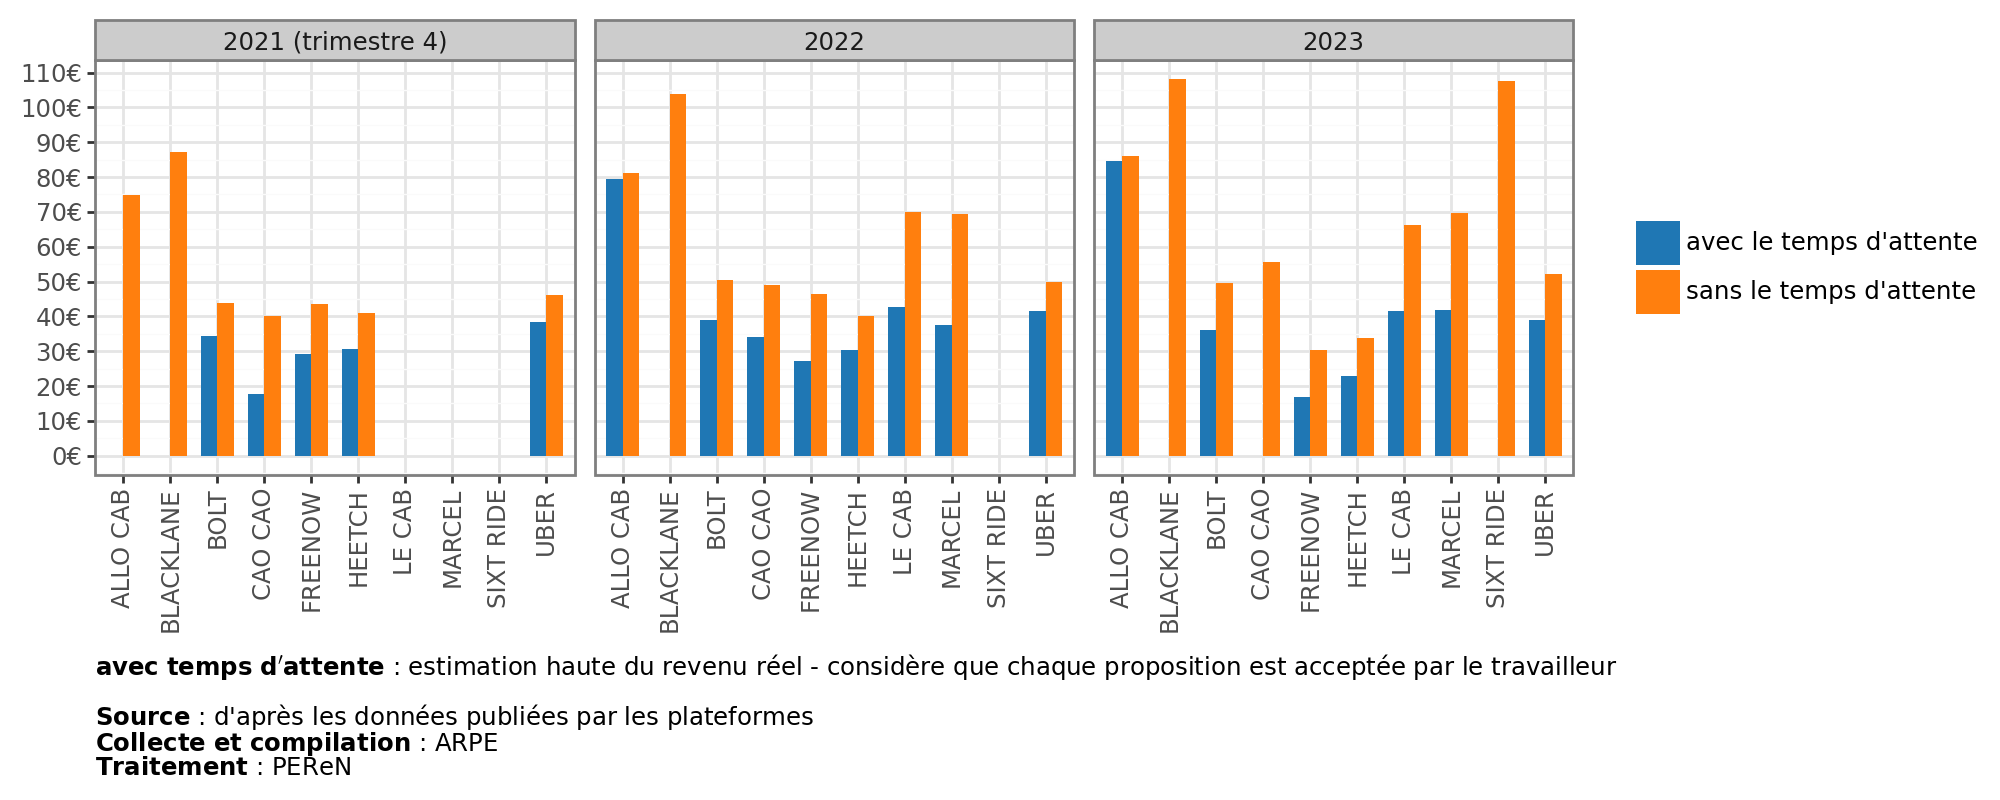

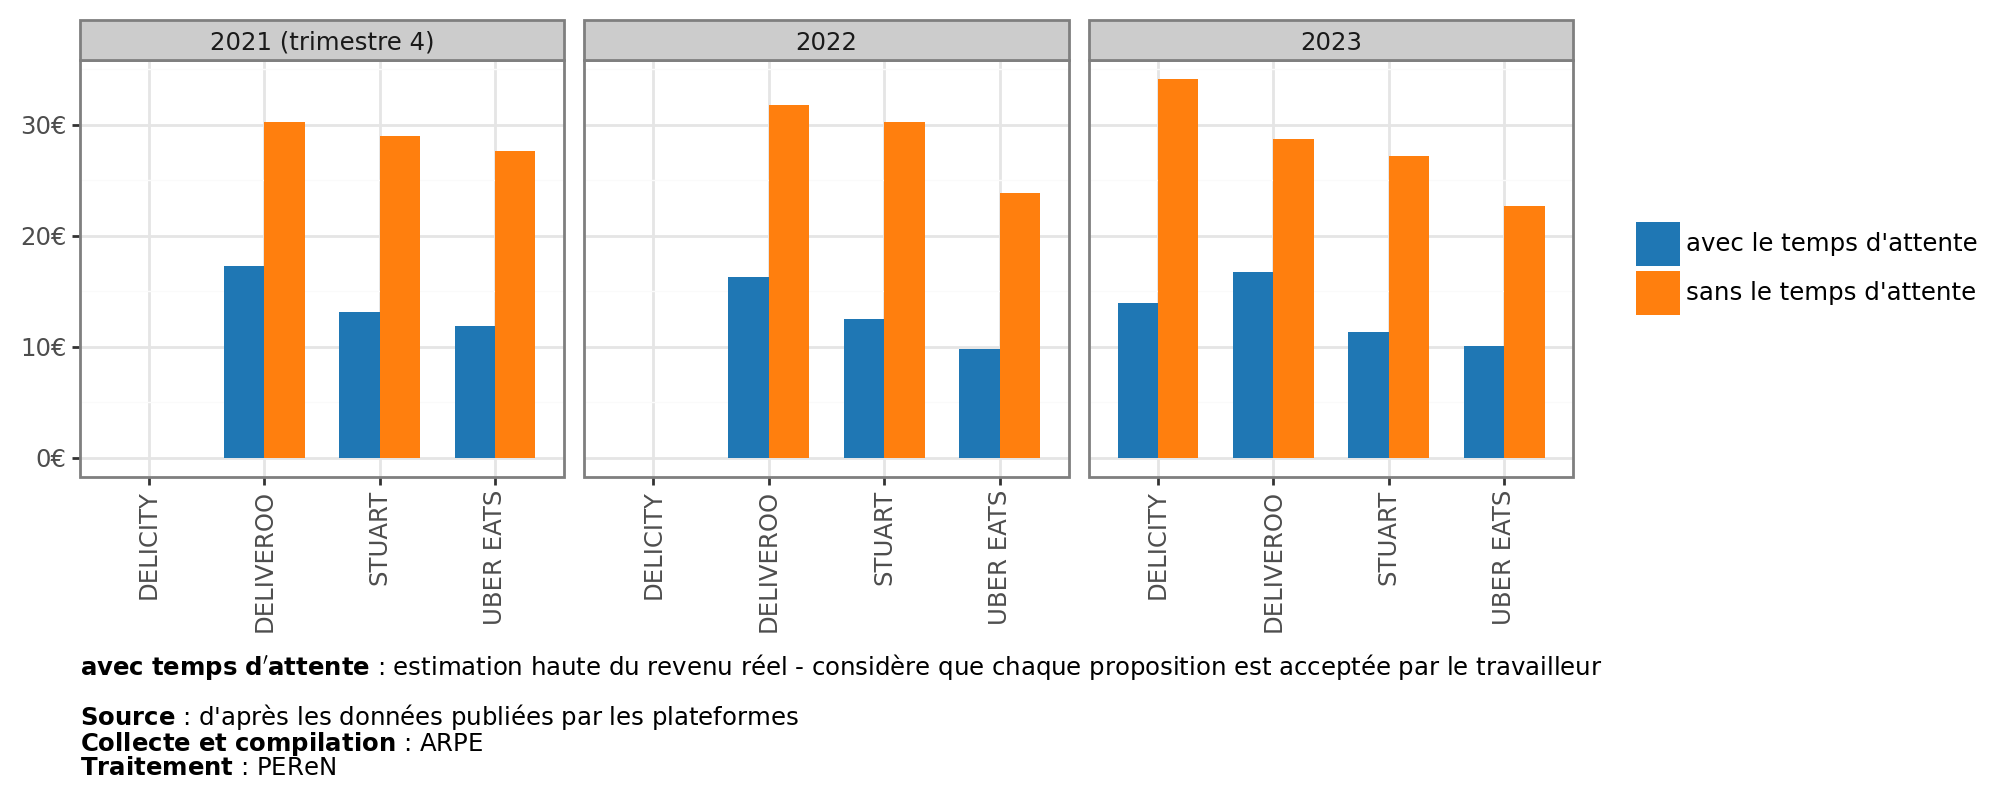

In [13]:
df_agr_vtc = get_dataframe_temps_attente(df_vtc_attente)
df_agr_livr = get_dataframe_temps_attente(df_livr_attente)

saving_graphs = False
print_graphs = True

for plot_smic in [True, False]:
    g_vtc = graph_revenu_attente(df_agr_vtc, "toutes", "", plot_smic=plot_smic)
    g_livr = graph_revenu_attente(df_agr_livr, "toutes", "", plot_smic=plot_smic)
    if print_graphs:
        print(g_vtc)
        print(g_livr)
    if saving_graphs:
        suffix = "avec" if plot_smic else "sans"
        suffix = f"-{suffix}_SMIC_charge"
        g_vtc.save(
            racine + f"vtc_revenu_horaire_moyen_modulo_attente_par_annee{suffix}.png",
            dpi=200,
        )
        g_livr.save(
            racine
            + f"livraison_revenu_horaire_moyen_modulo_attente_par_annee{suffix}.png",
            dpi=200,
        )

In [14]:
def graph_revenu_attente_inversion_axes(df, periode_activite, title, plot_smic=True):
    sub_df = df[
        (df["Durée étudiée"] == "prestation")
        & (df["Période d'activité"] == periode_activite)
    ].copy()
    if plot_smic:
        plateformes = sub_df["Plateforme"].unique()
        annees = sub_df["Année"].unique()
        sub_df.set_index(["Plateforme", "Année", "attente"], inplace=True)
        smic_per_year = {
            "2021 (trimestre 4)": 10.48 * 1.0355,
            "2022": 10.85 * 1.0355,
            "2023": 11.4 * 1.0355,
        }
        for platforme in plateformes:
            for annee in annees:
                sub_df.loc[(platforme, annee, "SMIC chargé")] = [
                    "prestation",
                    "toutes",
                    smic_per_year[annee],
                ]

    tmp = sub_df.reset_index()
    categories = [
        "avec le temps d'attente",
        "sans le temps d'attente",
        "SMIC chargé",
    ]
    tmp["attente"] = pd.Categorical(tmp["attente"], categories=categories, ordered=True)

    ncol = 5
    nrow = ceil(df["Plateforme"].unique().shape[0] / ncol)
    figsize = (10, 4.5 + (nrow - 1) * 2 / 3)
    g_caption = (
        plot_smic * (caption_smic_charge + "\n")
        + caption_temps_dattente
        + "\n\n"
        + caption
    )
    graph = (
        p9.ggplot(tmp)
        + p9.aes(
            x="Année",
            y="revenu_horaire",
            shape="attente",
            color="attente",
            group="attente",
        )
        + p9.geom_line()
        + p9.geom_point(size=3, alpha=0.75)
        # + p9.aes(x="Année", y="revenu_horaire", fill="attente")
        # + p9.geom_col(position="dodge")
        + p9.labs(
            title=title,
            y="",
            x="",
            caption=g_caption,
            color="",
            shape="",
        )
        + p9.theme_bw()
        + p9.scale_y_continuous(
            labels=lambda lab: ["%d€" % v for v in lab],
            limits=(0, tmp["revenu_horaire"].max() * 1.1),
        )
        + p9.scale_color_manual(values=tab10_palette)
        + p9.facet_wrap("Plateforme", ncol=ncol)
        + p9.theme(
            figure_size=figsize,
            plot_caption=p9.element_text(hjust=0),
            axis_text_x=p9.element_text(angle=90, hjust=0.5),
            legend_key=p9.element_rect(color="white"),
            legend_title=p9.element_blank(),
        )
    )

    return graph

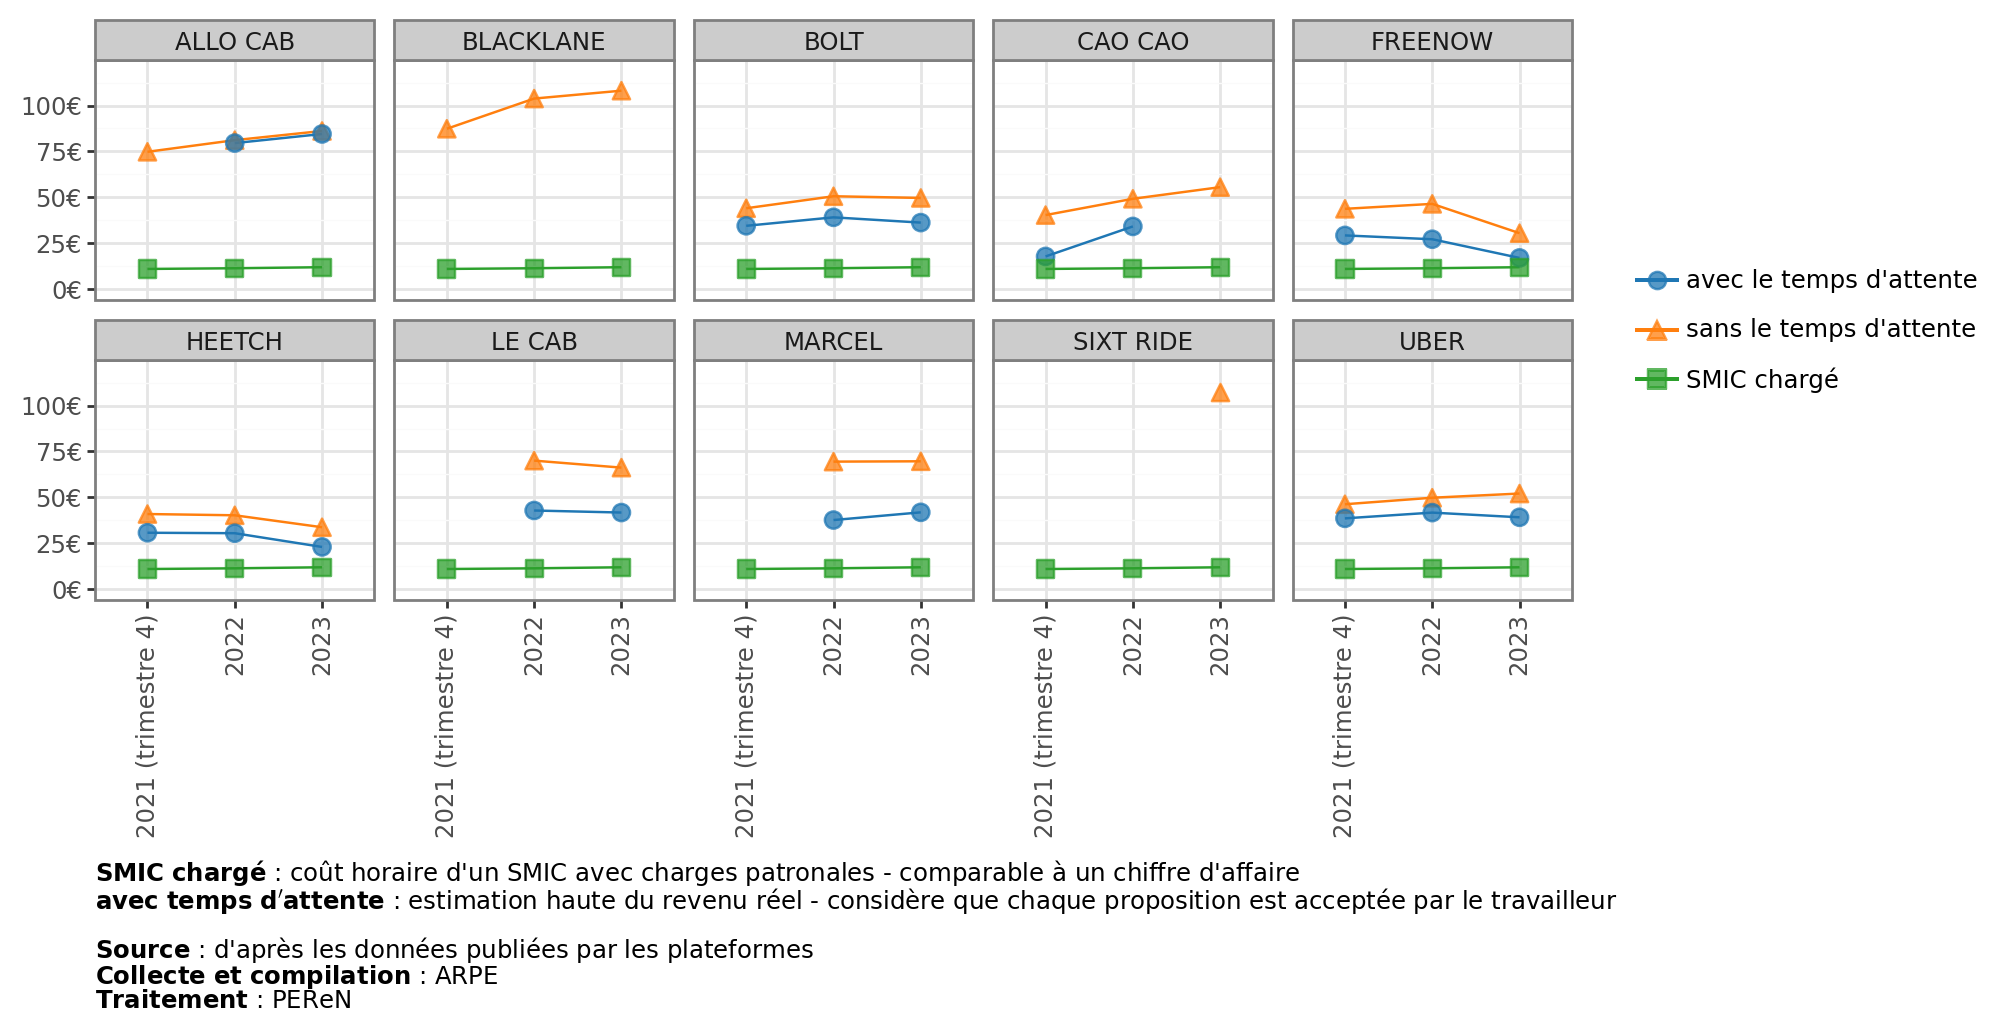

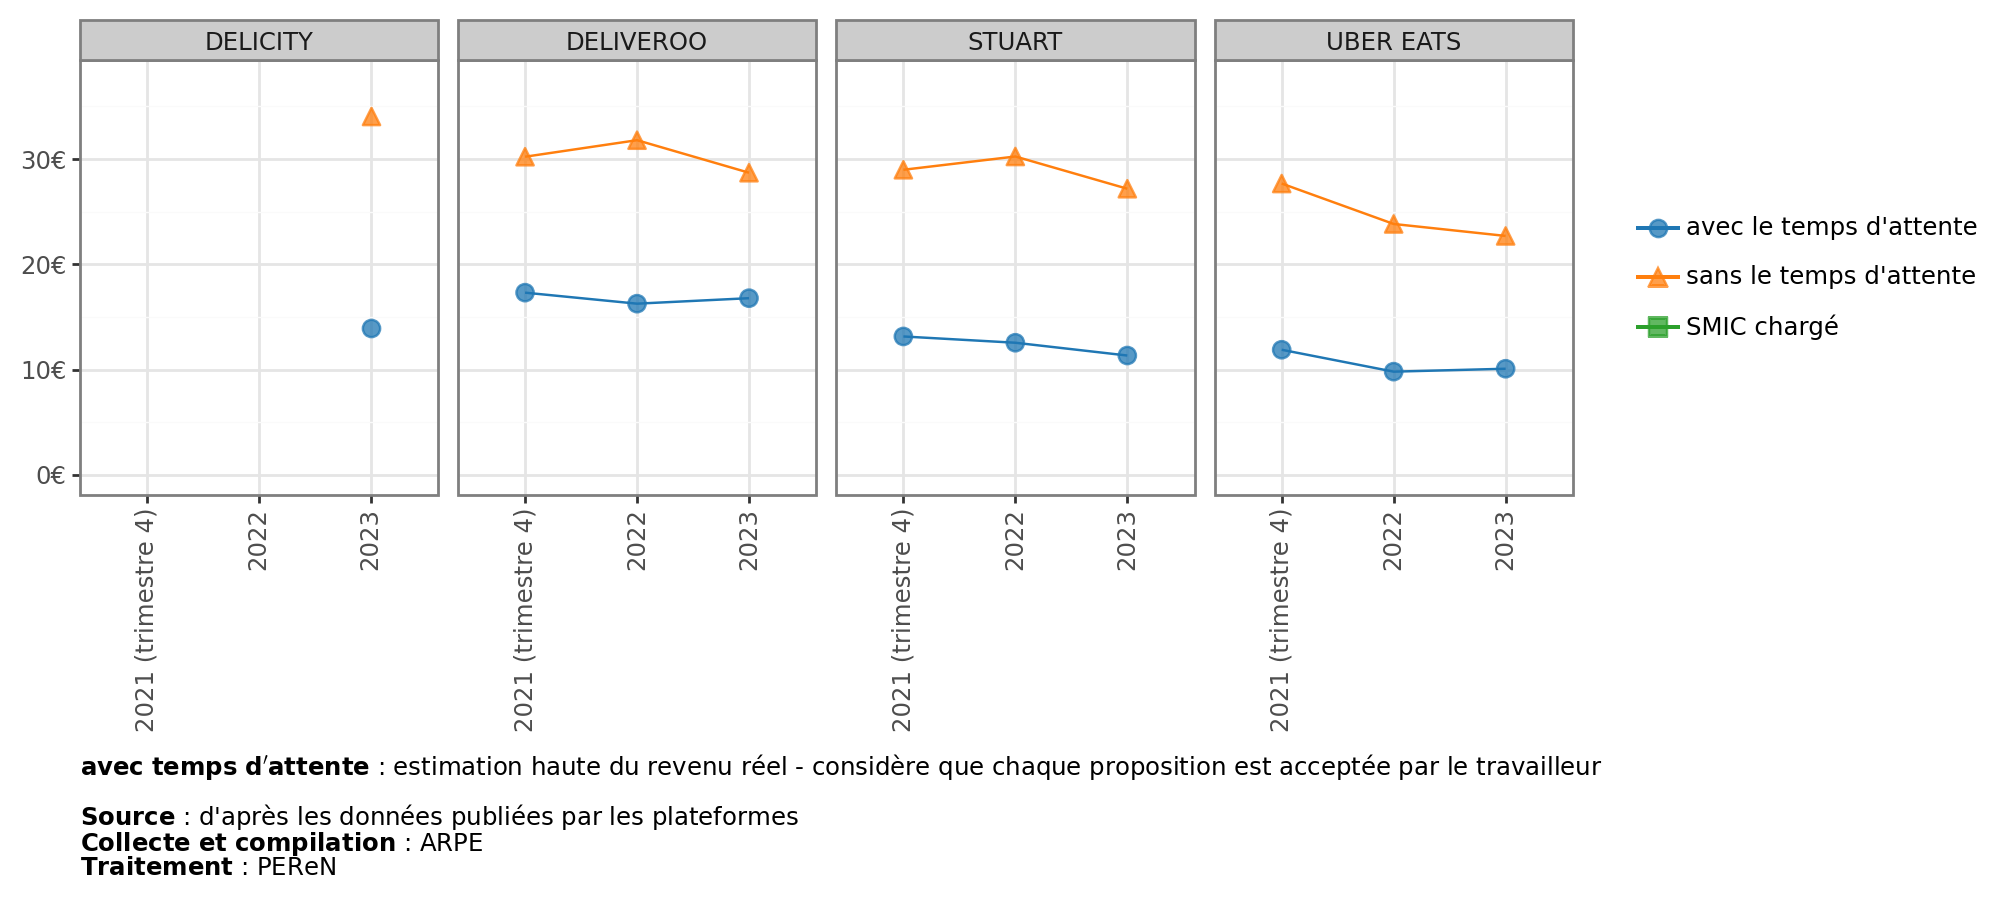

In [15]:
df_agr_vtc = get_dataframe_temps_attente(df_vtc_attente)
df_agr_livr = get_dataframe_temps_attente(df_livr_attente)

saving_graphs = False
print_graphs = True
for plot_smic in [True, False]:
    g_vtc = graph_revenu_attente_inversion_axes(df_agr_vtc, "toutes", "", plot_smic)
    g_livr = graph_revenu_attente_inversion_axes(df_agr_livr, "toutes", "", plot_smic)
    if print_graphs:
        print(g_vtc)
        print(g_livr)
    if saving_graphs:
        suffix = "avec" if plot_smic else "sans"
        suffix = f"-{suffix}_SMIC_charge"
        g_vtc.save(
            racine
            + f"vtc_revenu_horaire_moyen_modulo_attente_par_plateforme{suffix}.png",
            dpi=200,
        )
        g_livr.save(
            racine
            + f"livraison_revenu_horaire_moyen_modulo_attente_par_plateforme{suffix}.png",
            dpi=200,
        )